# Predicting Ride Counts for a Bike Sharing System

We are going to explore data from a bike sharing system and correlate it with weather data to try to predict demand. This can help the business make important decisions on inventory, staffing, and sales forecasting.

### Prep
The following Python modules need to be available. Instal with pip or conda

* matplotlib - chart visualization
* seaborn - enhancement to charting using matplotlib
* numpy - mathematical and statistics functions
* pandas - data manipulation and exploration
* tensorflow - machine learning

Once installed you can import the libraries and validate that the tensorflow version is 2.x.x

In [639]:
import os, math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import requests

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.3.0


In [640]:
# Declare data source and destination paths
raw_data_subdir = '..\\data\\raw'

clean_data_subdir = '..\\data\\prepared'
clean_weather_file = 'weather.csv'
clean_transaction_file = 'bike_transactions.csv'
clean_hourly_ride_file = 'hourly_rides.csv'

raw_data_dir = os.path.join(os.getcwd(), raw_data_subdir)
clean_data_dir = os.path.join(os.getcwd(), clean_data_subdir)


In [641]:
# Specify Azure storage account container path and files to retrieve
web_url = 'https://bikeshare.blob.core.windows.net/raw-data/'
data_files = [
'weather2019-2020.csv',
'201901-capitalbikeshare-tripdata.csv',
'201902-capitalbikeshare-tripdata.csv',
'201903-capitalbikeshare-tripdata.csv',
'201904-capitalbikeshare-tripdata.csv',
'201905-capitalbikeshare-tripdata.csv',
'201906-capitalbikeshare-tripdata.csv',
'201907-capitalbikeshare-tripdata.csv',
'201908-capitalbikeshare-tripdata.csv',
'201909-capitalbikeshare-tripdata.csv',
'201910-capitalbikeshare-tripdata.csv',
'201911-capitalbikeshare-tripdata.csv',
'201912-capitalbikeshare-tripdata.csv', 
'202001-capitalbikeshare-tripdata.csv',
'202002-capitalbikeshare-tripdata.csv',
'202003-capitalbikeshare-tripdata.csv',
'202004-capitalbikeshare-tripdata.csv',
'202005-capitalbikeshare-tripdata.csv',
'202006-capitalbikeshare-tripdata.csv',
'202007-capitalbikeshare-tripdata.csv',
'202008-capitalbikeshare-tripdata.csv',
'202009-capitalbikeshare-tripdata.csv',
'202010-capitalbikeshare-tripdata.csv',
'202011-capitalbikeshare-tripdata.csv',
'202012-capitalbikeshare-tripdata.csv',
]

# Download from Azure storage if not already downloaded
for file in data_files:
    path = os.path.join(raw_data_subdir, file)
    if not os.path.isfile(path):
        data = requests.get(web_url + file)
        with open(path, 'wb') as f:
            f.write(data.content)
 

# Weather file should be first in the list and can be popped from the front
weather_file = data_files.pop(0)
            

# Import the Weather Dataset

Import the dataset. Weather data can be requested from NOAA by filling out the form here: https://www.ncdc.noaa.gov/cdo-web/

The data I selected was the Daily summary for Dulles International Airport in Washington, DC covering years 2015-2017.

This included temperature, precipitation, wind speed and various weather codes that are explained in the NOAA documentation found here https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf


In [642]:
weather_df = pd.read_csv(filepath_or_buffer=os.path.join(raw_data_dir, weather_file),  parse_dates=[1])

# Replace Nulls will 0
weather_df.fillna(0, inplace=True)

# Rename columns
weather_df.rename(mapper={
        'AWND': 'Wind',
        'PRCP': 'Rain',
        'SNOW': 'Snow',
        'TAVG': 'Average temp',
        'TMAX': 'Hi temp',
        'TMIN': 'Lo temp',
    },axis=1, inplace = True)

# View the resulting dataframe
weather_df

,STATION,DATE,Wind,Rain,Snow,Average temp,Hi temp,Lo temp
0,USW00013743,2019-01-01,12.53,0.00,0.0,56,64,44
1,USW00013743,2019-01-02,5.59,0.00,0.0,46,48,42
2,USW00013743,2019-01-03,6.71,0.00,0.0,47,51,40
3,USW00013743,2019-01-04,5.14,0.04,0.0,43,50,36
4,USW00013743,2019-01-05,9.17,0.04,0.0,48,54,46
...,...,...,...,...,...,...,...,...
726,USW00013743,2020-12-27,5.82,0.00,0.0,33,43,26
727,USW00013743,2020-12-28,9.17,0.00,0.0,41,52,35
728,USW00013743,2020-12-29,11.18,0.00,0.0,41,43,32
729,USW00013743,2020-12-30,10.51,0.00,0.0,37,46,31


# Import the Bike Dataset

Import the datasets. Data Comes from Capital Bikeshare 
https://s3.amazonaws.com/capitalbikeshare-data/index.html
https://www.capitalbikeshare.com/system-data

The files are provided as csvs on a quarterly basis. Instead of manually merging. We can use the pandas library to concatenate the files into a single dataframe.

The data provided details every single bike ride transaction in the Capital Bikeshare system across all stations. This is more detail than we need and we are just trying to find total rides per hour. We modify the timestamp to just include date and hour and then group the transactions by hour to get ride count.

In [643]:
# Import all bikeshare data files in the directory
# glob_pattern = os.path.join(raw_data_dir, f"*{bike_file_suffix}")
dfs = []
for file in data_files:
    df= pd.read_csv(os.path.join(raw_data_subdir, file), parse_dates=[1,2])
    dfs.append(df)

# Merge all files into a single dataframe
bike_df = pd.concat(dfs).sort_values(by=['Start date'])


####################
# ADD REMOVAL of DURATION 86394.0 which is approx 60 days


### Group data by hour intervals

Use the groupby function to create a new dataframe that groups all rides by hour

In [644]:
# Truncate timestamp to hour
bike_hourly_df = bike_df.copy()
bike_hourly_df['Timestamp'] = bike_hourly_df['Start date'].dt.floor('h') 

# Get total Rides per hour
bike_hourly_df = bike_hourly_df.groupby(['Timestamp'], as_index = True)['Bike number'].count()

# View the resulting dataframe
bike_hourly_df

Timestamp
2019-01-01 00:00:00     60
2019-01-01 01:00:00    107
2019-01-01 02:00:00    102
2019-01-01 03:00:00     25
2019-01-01 04:00:00     14
                      ... 
2020-03-31 19:00:00     51
2020-03-31 20:00:00     25
2020-03-31 21:00:00      9
2020-03-31 22:00:00      8
2020-03-31 23:00:00      9
Name: Bike number, Length: 10917, dtype: int64

Merge the datasets. They will be merged on Timestamp from the bike date and DATE from the weather data. This is done using the merge_asof function so that an exact match isn't required. Our bike data includes a time component which the weather data does not. We are essentially just matching the Timestamp to any DATE field that is less than or equal, in other words they are on the same date.

In [645]:
# Timestamp in bike_df are hourly, timestamp in weather_df are daily
# Merge on nearest timestamp that is not greater than the Timestamp (i.e same day)

data_df = pd.merge_asof(bike_hourly_df.reset_index(), weather_df, left_on='Timestamp', right_on = 'DATE', direction='backward').set_index(['Timestamp']).rename(columns = {'Bike number':'Ride count'})

data_df.head()

,Ride count,STATION,DATE,Wind,Rain,Snow,Average temp,Hi temp,Lo temp
Timestamp,,,,,,,,,
2019-01-01 00:00:00,60,USW00013743,2019-01-01,12.53,0.0,0.0,56,64,44
2019-01-01 01:00:00,107,USW00013743,2019-01-01,12.53,0.0,0.0,56,64,44
2019-01-01 02:00:00,102,USW00013743,2019-01-01,12.53,0.0,0.0,56,64,44
2019-01-01 03:00:00,25,USW00013743,2019-01-01,12.53,0.0,0.0,56,64,44
2019-01-01 04:00:00,14,USW00013743,2019-01-01,12.53,0.0,0.0,56,64,44


# Feature Engineering

We extrapolate attributes from the dataset to give us additional features (or variables) to use as inputs into our machine learning model. A timestamp may not correlate well with the Ride Count we are trying to predict but by extracting the day of the week we can predict spikes based on whether it is a work day or the weekend. The features I have added are 

* Hour
* Day of week
* Month
* Day of year
* Weekend (boolean flag to denote that it is saturday or sunday)
* Holiday (boolean flag to denote that it is a major holiday that may effect bike demand. This is done by creating a holiday calendar object to account for shifting holidays)
* Season (1 - Spring, 2 - Summer, 3 - Fall, 4 - Winter)

Some of these feature columns will be dropped and not used in our model, but are useful for data analysis to find patterns.

In [646]:
# Add Hour
data_df.insert(3,'Hour', data_df.index.hour)
# Add Day of week
data_df.insert(4,'Day of week', data_df.index.dayofweek)
# Add Month
data_df.insert(5,'Month', data_df.index.month)
# Add Day of year
data_df.insert(6, 'Day of year', data_df.index.dayofyear)
# Add weekend flag
# true if day of week is 5 or 6 (saturday or sunday)
days = [0, 0, 0, 0, 0, 1, 1]
days_to_weekend = dict(zip(range(0,7), days))
data_df.insert(7, 'Weekend', data_df['Day of week'].map(days_to_weekend))
# Add Year
data_df.insert(8,'Year', data_df.index.year)

In [647]:
# Create Holiday Calendar
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, \
    nearest_workday, previous_friday, next_monday, \
    USMartinLutherKingJr, USPresidentsDay, USMemorialDay, \
    USLaborDay, USThanksgivingDay

from pandas import DateOffset
from dateutil.relativedelta import FR, MO, SA, SU, TH, TU, WE
import datetime as dt

class USHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('NewYearsDay', month=1, day=1, observance=nearest_workday),
        USMartinLutherKingJr,
        USPresidentsDay,
        USMemorialDay,
        Holiday('USIndependenceDay', month=7, day=4, observance=nearest_workday),
        USLaborDay,
        USThanksgivingDay,
        Holiday('DayAfterThanksgiving', month=11, day=1, offset=[DateOffset(weekday=TH(4)), DateOffset(1)]),
        Holiday('ChristmasEve', month=12, day=24, observance=previous_friday),
        Holiday('Christmas', month=12, day=25, observance=next_monday)
    ]


def get_holidays(yearstart, yearend):
    cal = USHolidayCalendar()

    return cal.holidays(dt.datetime(yearstart-1, 12, 31), dt.datetime(yearend, 12, 31))

holidays = get_holidays(2015,2020)

data_df.insert(9,'Holiday',data_df['DATE'].astype(str).isin(holidays.astype(str)).astype(int))


In [648]:
# Add Seasons 
# Winter 1, Spring 2, Summer 3, Fall 4 based on month
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]
month_to_season = dict(zip(range(1,13), seasons))
data_df['Season'] = data_df['Month'].map(month_to_season)

In [649]:
# Can drop Date  and station columns after merge and feature engineering.
data_df.drop(['DATE', 'STATION'], axis=1, inplace=True)

In [650]:

data_df['dt'] = pd.to_datetime(data_df.index)
data_df['Date'] = data_df['dt'].dt.date
data_df

,Ride count,Hour,Day of week,Month,Day of year,Weekend,Year,Holiday,Wind,Rain,Snow,Average temp,Hi temp,Lo temp,Season,dt,Date
Timestamp,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,60,0,1,1,1,0,2019,1,12.53,0.00,0.0,56,64,44,1,2019-01-01 00:00:00,2019-01-01
2019-01-01 01:00:00,107,1,1,1,1,0,2019,1,12.53,0.00,0.0,56,64,44,1,2019-01-01 01:00:00,2019-01-01
2019-01-01 02:00:00,102,2,1,1,1,0,2019,1,12.53,0.00,0.0,56,64,44,1,2019-01-01 02:00:00,2019-01-01
2019-01-01 03:00:00,25,3,1,1,1,0,2019,1,12.53,0.00,0.0,56,64,44,1,2019-01-01 03:00:00,2019-01-01
2019-01-01 04:00:00,14,4,1,1,1,0,2019,1,12.53,0.00,0.0,56,64,44,1,2019-01-01 04:00:00,2019-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31 19:00:00,51,19,1,3,91,0,2020,0,10.96,0.12,0.0,54,56,43,2,2020-03-31 19:00:00,2020-03-31
2020-03-31 20:00:00,25,20,1,3,91,0,2020,0,10.96,0.12,0.0,54,56,43,2,2020-03-31 20:00:00,2020-03-31
2020-03-31 21:00:00,9,21,1,3,91,0,2020,0,10.96,0.12,0.0,54,56,43,2,2020-03-31 21:00:00,2020-03-31


### Output prepared data
The prepared data can be written to a CSV file for reuse or import into a database

In [651]:
data_df.to_csv(os.path.join(clean_data_dir, clean_hourly_ride_file))
# bike_df.to_csv(os.path.join(clean_data_dir, clean_transaction_file))
weather_df.to_csv(os.path.join(clean_data_dir, clean_weather_file))

In [652]:
data_df

,Ride count,Hour,Day of week,Month,Day of year,Weekend,Year,Holiday,Wind,Rain,Snow,Average temp,Hi temp,Lo temp,Season,dt,Date
Timestamp,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,60,0,1,1,1,0,2019,1,12.53,0.00,0.0,56,64,44,1,2019-01-01 00:00:00,2019-01-01
2019-01-01 01:00:00,107,1,1,1,1,0,2019,1,12.53,0.00,0.0,56,64,44,1,2019-01-01 01:00:00,2019-01-01
2019-01-01 02:00:00,102,2,1,1,1,0,2019,1,12.53,0.00,0.0,56,64,44,1,2019-01-01 02:00:00,2019-01-01
2019-01-01 03:00:00,25,3,1,1,1,0,2019,1,12.53,0.00,0.0,56,64,44,1,2019-01-01 03:00:00,2019-01-01
2019-01-01 04:00:00,14,4,1,1,1,0,2019,1,12.53,0.00,0.0,56,64,44,1,2019-01-01 04:00:00,2019-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31 19:00:00,51,19,1,3,91,0,2020,0,10.96,0.12,0.0,54,56,43,2,2020-03-31 19:00:00,2020-03-31
2020-03-31 20:00:00,25,20,1,3,91,0,2020,0,10.96,0.12,0.0,54,56,43,2,2020-03-31 20:00:00,2020-03-31
2020-03-31 21:00:00,9,21,1,3,91,0,2020,0,10.96,0.12,0.0,54,56,43,2,2020-03-31 21:00:00,2020-03-31


# Explore the data

Do some exploratory data analysis to make sure there aren't major anomalies in the data and to find patterns that can help in selecting features that will build the most effective model. Start with basic checks for nulls and any outlying data.

In [617]:
data_df.isnull().sum()

Ride count      0
Hour            0
Day of week     0
Month           0
Day of year     0
Weekend         0
Year            0
Holiday         0
Wind            0
Rain            0
Snow            0
Average temp    0
Hi temp         0
Lo temp         0
Season          0
dt              0
Date            0
dtype: int64

In [585]:
data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Ride count,2170.0,247.649770,250.856317,1.00,41.00,185.0,365.00,1380.00
Hour,2170.0,11.556221,6.910267,0.00,6.00,12.0,18.00,23.00
Day of week,2170.0,3.004608,2.001608,0.00,1.00,3.0,5.00,6.00
Month,2170.0,1.998157,0.824362,1.00,1.00,2.0,3.00,3.00
Day of year,2170.0,45.917512,26.194226,1.00,23.00,46.0,69.00,91.00
Weekend,2170.0,0.286636,0.452294,0.00,0.00,0.0,1.00,1.00
Year,2170.0,2020.000000,0.000000,2020.00,2020.00,2020.0,2020.00,2020.00
Holiday,2170.0,0.033180,0.179147,0.00,0.00,0.0,0.00,1.00
Wind,2170.0,8.924134,3.322127,1.12,6.49,8.5,11.41,17.00
Rain,2170.0,0.091346,0.190899,0.00,0.00,0.0,0.09,1.23


Then start to explore the date using different charts to compare how different features may effect the Ride count.

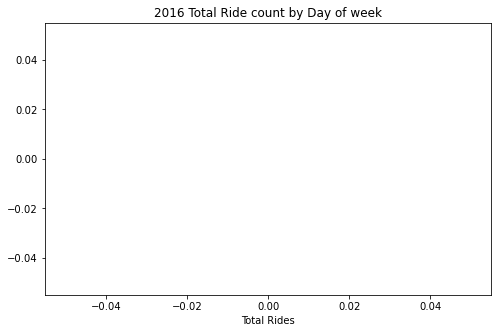

In [586]:
fig, ax = plt.subplots(figsize = ( 8 , 5 ))
rides_2016 = data_df.where(data_df['Year']==2019)
ridesbyday_bike_df = rides_2016.groupby(['Day of week'], as_index = False)['Ride count'].sum()
x=ridesbyday_bike_df['Day of week']
y=ridesbyday_bike_df['Ride count']
plt.title('2016 Total Ride count by Day of week')
plt.xlabel('Day of week')
plt.xlabel('Total Rides')
plt.plot(x,y)
plt.show()

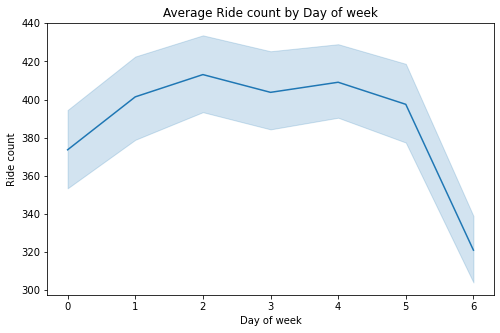

In [504]:
fig, ax = plt.subplots(figsize = ( 8 , 5 ))
sns.lineplot(data=data_df, x='Day of week',y='Ride count')
plt.title('Average Ride count by Day of week')
plt.show()

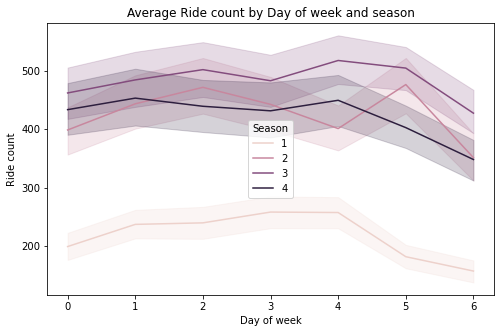

In [505]:
fig, ax = plt.subplots(figsize = ( 8 , 5 ))
sns.lineplot(data=data_df, x='Day of week',y='Ride count',hue='Season')
plt.title('Average Ride count by Day of week and season')
plt.show()

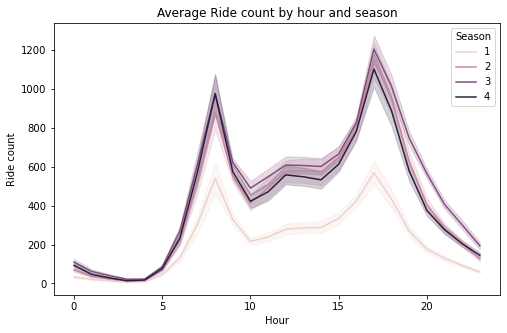

In [506]:
fig, ax = plt.subplots(figsize = ( 8 , 5 ))
sns.lineplot(data=data_df, x='Hour',y='Ride count',hue='Season')
plt.title('Average Ride count by hour and season')
plt.show()

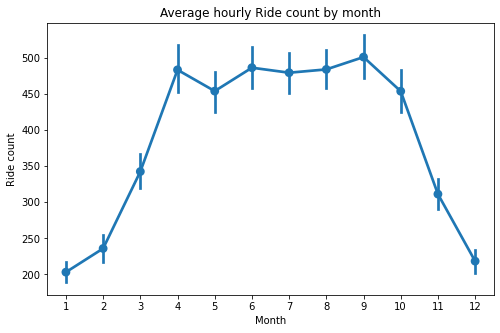

In [507]:
fig, ax = plt.subplots(figsize = ( 8 , 5 ))
sns.pointplot(data=data_df, x='Month',y='Ride count')
plt.title('Average hourly Ride count by month')
plt.show()

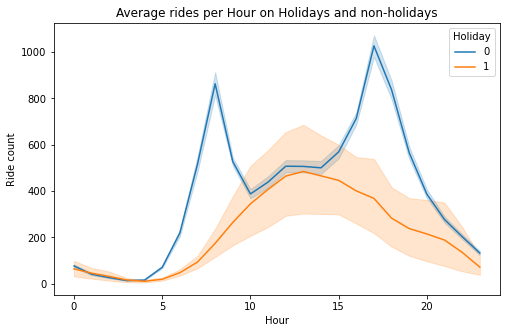

In [508]:
fig, ax = plt.subplots(figsize = ( 8 , 5 ))
sns.lineplot(data=data_df, x='Hour',y='Ride count',hue='Holiday',color="Or")
plt.title('Average rides per Hour on Holidays and non-holidays')
plt.show()

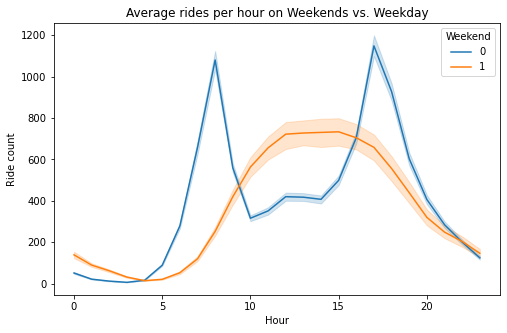

In [509]:
fig, ax = plt.subplots(figsize = ( 8 , 5 ))
sns.lineplot(data=data_df, x='Hour',y='Ride count',hue='Weekend',color="Or")
plt.title('Average rides per hour on Weekends vs. Weekday')
plt.show()

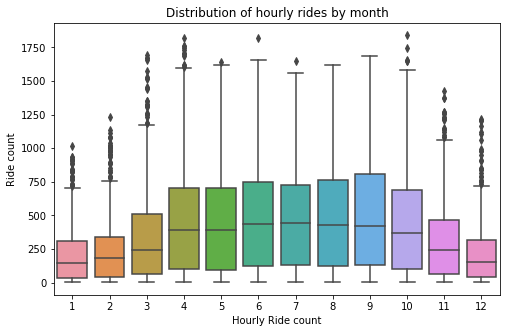

In [510]:
fig, ax = plt.subplots(figsize = ( 8 , 5 ))
sns.boxplot(data=data_df, x='Month', y='Ride count')
plt.title('Distribution of hourly rides by month')
plt.xlabel('Hourly Ride count')
plt.show()

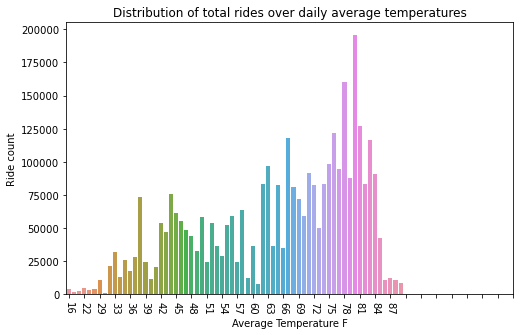

In [511]:
fig, ax = plt.subplots(figsize = ( 8 , 5 ))
temp_df=data_df.groupby(['Average temp']).sum()
sns.barplot(data=temp_df,x=temp_df.index,y='Ride count')
plt.xticks(rotation=270)
plt.title('Distribution of total rides over daily average temperatures')
plt.xlabel('Average Temperature F')
plt.xticks(np.arange(0,90,3))
plt.show()

Heatmaps and pairplots are another good way of finding correlations in the data. The closer to an absolute value of 1 the more there is correlation. We can see that all features have a 1:1 correlation with themselves and the temperature values are all closely related.  We are looking for correlations with ride count.  These may not be the only items we choose as features as some items may not have a high correlation but are helpful for removing outlying data like the "Holiday" data point.

Pairplots are another good way of viewing correlation between different data.

<AxesSubplot:>

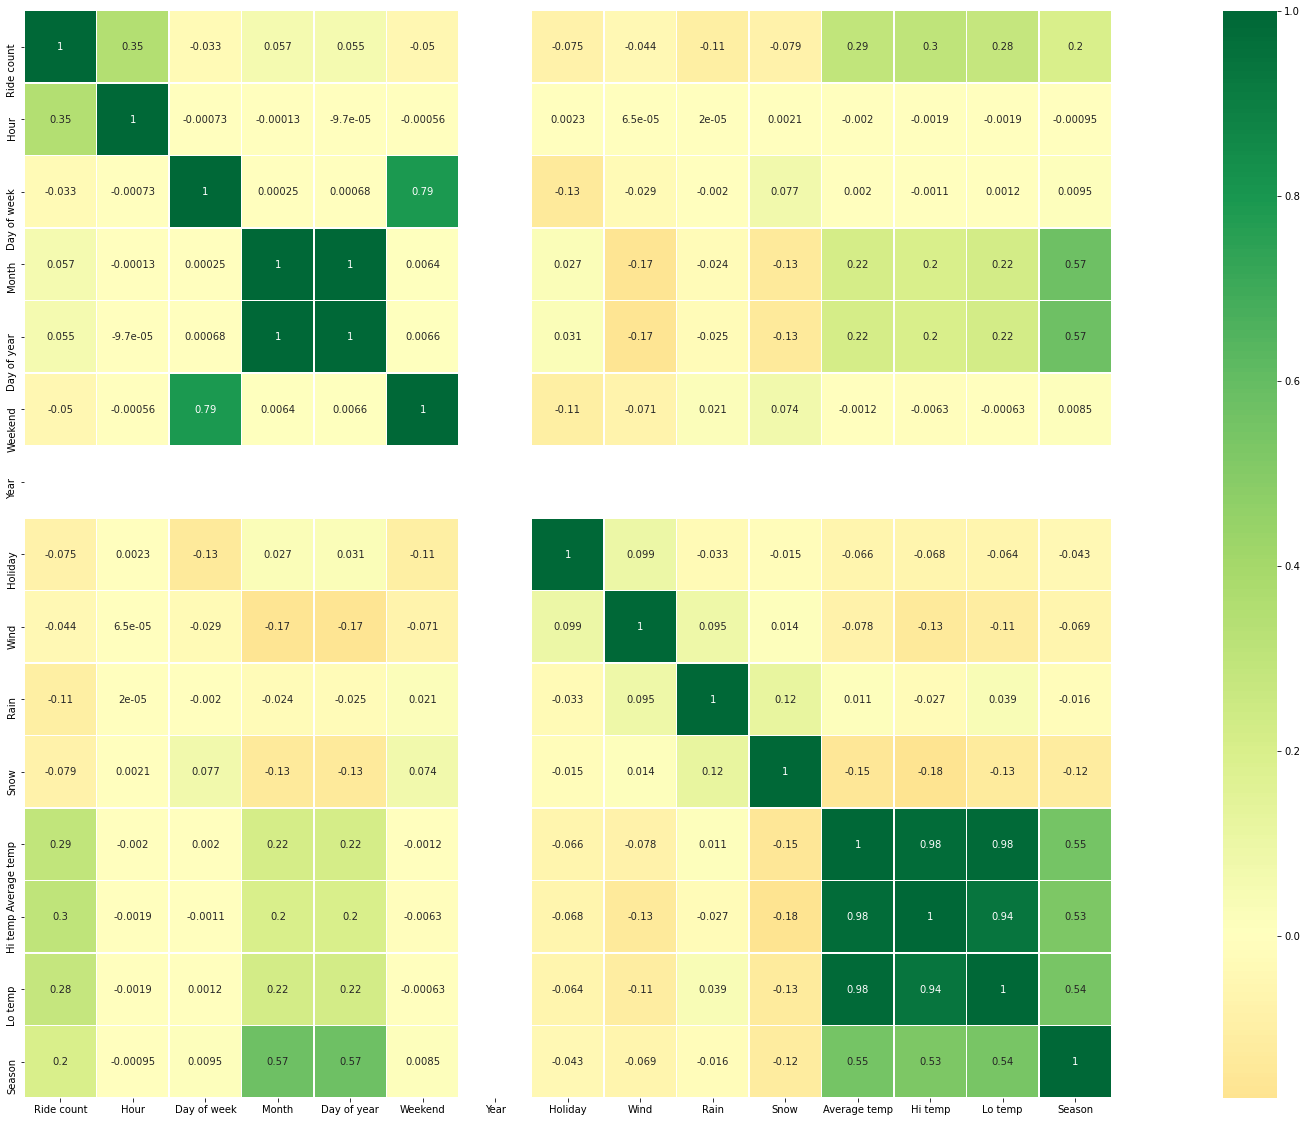

In [512]:
plt.figure(figsize=(40,20))
sns.heatmap(data_df.corr(),square=True,annot=True,linewidths=.5,center=0,cmap="RdYlGn")

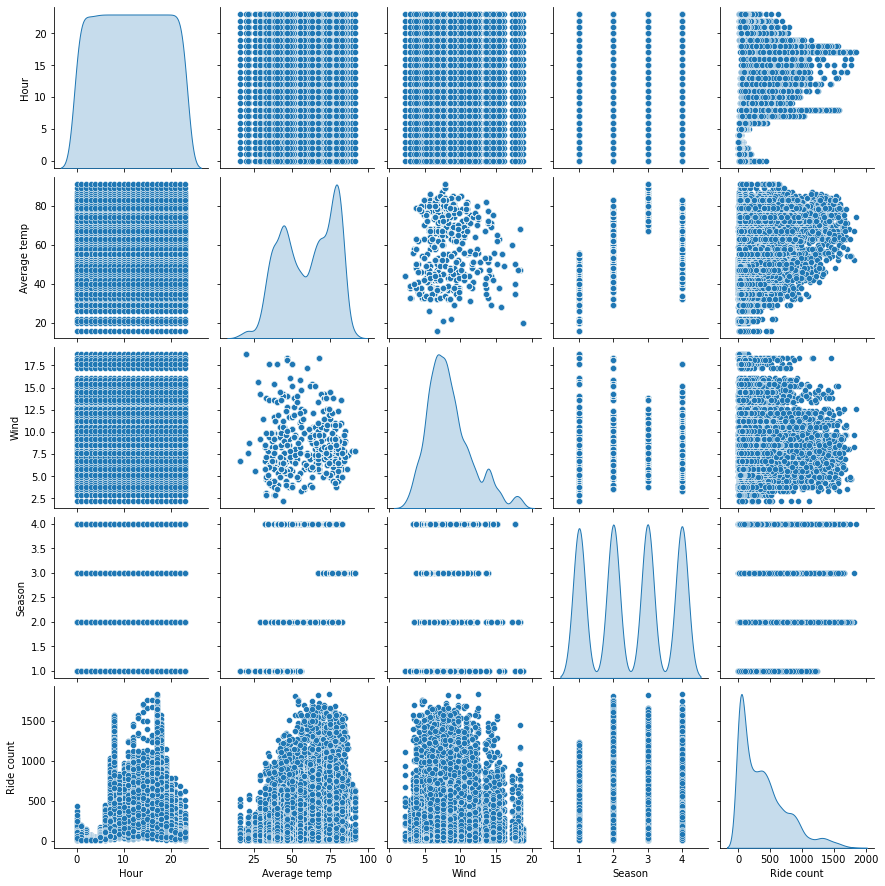

In [513]:
sns.pairplot(data_df[['Hour','Average temp','Wind','Season','Ride count']],diag_kind='kde')

# Prepare data for training the model

There are a couple manipulations to the data types we can make to make training the model more effective. The first is to convert the seasons from a 1-4 category to one-hot encoding. This makes a separate variable for each season which is a boolean. The second is to change the snow value to a boolean instead of a scalar. Snow counts are infrequent and tend to have a large impact on rides regardless of the amount so a boolean appears to be more effective.

To train the model we need to split the data into training and test data. If the model trains on the same data that it is being tested against, it may falsely appear that our model is very accurate but that is only because it is already aware of what the test data looks like. When using this model for a real prediction it might not give us the result we expect. By testing against data that the model has not seen we get a better measure of accuracy.

The training and test data is then split further into date that includes our feaures (or input variables) and labels (or outputs, the thing we want to predict). We have many columns in our source data, so we pick out only the features that we have found will correlate with the output through our analysis.

In [653]:
# Convert Season to one-hot variables
data_df['Season'] = data_df['Season'].map({1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'})
data_df = pd.get_dummies(data_df, prefix='', prefix_sep='', columns=['Season'])

In [654]:
# Set snow to a boolean
data_df.loc[data_df['Snow'] != 0, 'Snow'] = 1.0

In [655]:
data_df.reset_index(inplace=True)
data_df.drop(['Timestamp'],axis=1, inplace=True)
data_df

,Ride count,Hour,Day of week,Month,Day of year,Weekend,Year,Holiday,Wind,Rain,Snow,Average temp,Hi temp,Lo temp,dt,Date,Fall,Spring,Summer,Winter
0,60,0,1,1,1,0,2019,1,12.53,0.00,0.0,56,64,44,2019-01-01 00:00:00,2019-01-01,0,0,0,1
1,107,1,1,1,1,0,2019,1,12.53,0.00,0.0,56,64,44,2019-01-01 01:00:00,2019-01-01,0,0,0,1
2,102,2,1,1,1,0,2019,1,12.53,0.00,0.0,56,64,44,2019-01-01 02:00:00,2019-01-01,0,0,0,1
3,25,3,1,1,1,0,2019,1,12.53,0.00,0.0,56,64,44,2019-01-01 03:00:00,2019-01-01,0,0,0,1
4,14,4,1,1,1,0,2019,1,12.53,0.00,0.0,56,64,44,2019-01-01 04:00:00,2019-01-01,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10912,51,19,1,3,91,0,2020,0,10.96,0.12,0.0,54,56,43,2020-03-31 19:00:00,2020-03-31,0,1,0,0
10913,25,20,1,3,91,0,2020,0,10.96,0.12,0.0,54,56,43,2020-03-31 20:00:00,2020-03-31,0,1,0,0
10914,9,21,1,3,91,0,2020,0,10.96,0.12,0.0,54,56,43,2020-03-31 21:00:00,2020-03-31,0,1,0,0
10915,8,22,1,3,91,0,2020,0,10.96,0.12,0.0,54,56,43,2020-03-31 22:00:00,2020-03-31,0,1,0,0


In [851]:
# Specify features and labels
features = ['Hour','Hi temp','Lo temp','Day of week','Month','Fall','Spring','Summer','Winter','Holiday','Wind','Rain','Snow']
labels = ['Ride count']

train_features, test_features, train_labels, test_labels = train_test_split(data_df[features], 
                                                                    data_df[labels], test_size=0.1, random_state=1,)

# Split data into training and test data
# train_df = data_df.sample(frac=0.9, random_state=1)
# test_df = data_df.drop(train_df.index)

# train_features = train_df.loc[:,features]
# test_features = test_df.loc[:,features]

# train_labels = train_df.loc[:,labels]
# test_labels = test_df.loc[:,labels]

## Normalize the data

Our features work on different numeric scales. Some are a boolean 1 or 0 and some have much larger ranges for Temperature, Hour, or Wind speed. Normalizing minimizes the effect this may have on our model by converting them to using the same value range. A normalizer object is created to keep track of this conversion and is an input into our model.

In [852]:
train_features.describe().transpose()[['mean', 'std', 'min', 'max']]

,mean,std,min,max
Hour,11.514402,6.908342,0.00,23.00
Hi temp,66.346158,18.043649,24.00,99.00
Lo temp,49.642341,16.427412,10.00,81.00
Day of week,2.989720,2.001220,0.00,6.00
Month,5.612417,3.581958,1.00,12.00
Fall,0.199288,0.399485,0.00,1.00
Spring,0.271145,0.444573,0.00,1.00
Summer,0.202239,0.401690,0.00,1.00
Winter,0.327328,0.469262,0.00,1.00
Holiday,0.028601,0.166689,0.00,1.00


In [853]:
normalizer = preprocessing.Normalization()
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[1.1514402e+01 6.6346161e+01 4.9642342e+01 2.9897201e+00 5.6124172e+00
 1.9928753e-01 2.7114505e-01 2.0223919e-01 3.2732823e-01 2.8600508e-02
 8.5673609e+00 1.1056590e-01 2.7480915e-02]


In [854]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[21.   54.   37.    6.    3.    0.    1.    0.    0.    0.    7.61  0.
   0.  ]]

Normalized: [[ 1.37 -0.68 -0.77  1.5  -0.73 -0.5   1.64 -0.5  -0.7  -0.17 -0.3  -0.38
  -0.17]]


# Build and train the model

We are now ready to create our machine learning model and train it to make predictions. We will first define a couple functions to help us create the model and plot the loss (a type of measure for accuracy) to judge how well our model has been trained.

The type of model we are creating uses the keras API and is a sequential model. It uses multiple hiddlen layers of neurons between the input and output layers and is therefore classified as a Deep Neural Network (DNN).

In [855]:
def create_model(normalizer, learning_rate):
  model = keras.Sequential([
      normalizer,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(learning_rate),
                metrics=[
                    metrics.RootMeanSquaredError(name='root_mean_squared_error')
                ]
    )
  return model

def plot_loss(results):
  plt.plot(results.history['loss'], label='loss')
  plt.plot(results.history['val_loss'], label='val_loss')
  plt.ylim([0, max(results.history['loss'])])
  plt.xlabel('Epoch')
  plt.ylabel('Error [Ride count]')
  plt.legend()
  plt.grid(True)
  plt.show()

def plot_metric(results, metric, color='b'):
  limits = [ 0, max(results.history[metric]), ]
  plt.plot(results.history[metric], label=metric, color=color)
  plt.ylim(limits)
  plt.xlabel('Epoch')
  plt.ylabel('Error [Ride count]')
  plt.legend()
  plt.grid(True)
  plt.show()

In [856]:
learning_rate = 0.009
model = create_model(normalizer, learning_rate)
model.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_35 (Normalizat (None, 13)                27        
_________________________________________________________________
dense_150 (Dense)            (None, 64)                896       
_________________________________________________________________
dense_151 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_152 (Dense)            (None, 1)                 65        
Total params: 5,148
Trainable params: 5,121
Non-trainable params: 27
_________________________________________________________________


In [857]:
# This statement can be used to reload from a checkpoint if you have saved the model to a file
# dnn_model.load_weights('./models/checkpoint')

## Training
Now that the model is built, we can start training. We use a validation split, that further splits our training data set into training and validation data. In this way the model can check for loss against the validation data to judge how well it is doing during training instead of having to wait until the testing phase.

We also set the number of epochs which are the number of training iterations we will run against the dataset. Batch size determines how many data points are processed at a time.

The results of the training are captured so we can plot the improvement in the loss measurement over the training iterations.

In [858]:
history = model.fit(
    train_features, train_labels,
#     steps_per_epoch=1000,
#    batch_size =  16,
    validation_split = 0.05,
    epochs=250,
    verbose=1
)

Epoch 1/250
292/292 [==============================] - 0s 1ms/step - loss: 238.0543 - root_mean_squared_error: 342.4377 - val_loss: 219.3295 - val_root_mean_squared_error: 308.4229
Epoch 2/250
292/292 [==============================] - 0s 1ms/step - loss: 220.5806 - root_mean_squared_error: 319.7029 - val_loss: 214.6968 - val_root_mean_squared_error: 309.2428
Epoch 3/250
292/292 [==============================] - 0s 876us/step - loss: 190.7799 - root_mean_squared_error: 295.1233 - val_loss: 167.1600 - val_root_mean_squared_error: 272.0974
Epoch 4/250
292/292 [==============================] - 0s 758us/step - loss: 158.1795 - root_mean_squared_error: 260.6475 - val_loss: 149.5125 - val_root_mean_squared_error: 242.4251
Epoch 5/250
292/292 [==============================] - 0s 884us/step - loss: 142.5554 - root_mean_squared_error: 242.3006 - val_loss: 140.4356 - val_root_mean_squared_error: 225.6266
Epoch 6/250
292/292 [==============================] - 0s 1ms/step - loss: 132.6775 - roo

292/292 [==============================] - 0s 1ms/step - loss: 65.4543 - root_mean_squared_error: 107.6612 - val_loss: 68.1085 - val_root_mean_squared_error: 110.5857
Epoch 47/250
292/292 [==============================] - 0s 1ms/step - loss: 64.9595 - root_mean_squared_error: 107.5088 - val_loss: 65.1587 - val_root_mean_squared_error: 107.0014
Epoch 48/250
292/292 [==============================] - 0s 949us/step - loss: 64.9541 - root_mean_squared_error: 108.0391 - val_loss: 72.9171 - val_root_mean_squared_error: 113.0909
Epoch 49/250
292/292 [==============================] - 0s 1ms/step - loss: 63.9873 - root_mean_squared_error: 106.5127 - val_loss: 68.2837 - val_root_mean_squared_error: 113.0434
Epoch 50/250
292/292 [==============================] - 0s 1ms/step - loss: 64.8928 - root_mean_squared_error: 107.0318 - val_loss: 64.9263 - val_root_mean_squared_error: 107.5375
Epoch 51/250
292/292 [==============================] - 0s 1ms/step - loss: 63.1602 - root_mean_squared_error: 

Epoch 92/250
292/292 [==============================] - 1s 4ms/step - loss: 55.2512 - root_mean_squared_error: 96.0239 - val_loss: 61.4421 - val_root_mean_squared_error: 103.4507
Epoch 93/250
292/292 [==============================] - 1s 3ms/step - loss: 56.0433 - root_mean_squared_error: 95.7232 - val_loss: 64.3347 - val_root_mean_squared_error: 100.1274
Epoch 94/250
292/292 [==============================] - 1s 3ms/step - loss: 56.5028 - root_mean_squared_error: 97.1599 - val_loss: 61.9526 - val_root_mean_squared_error: 101.1447
Epoch 95/250
292/292 [==============================] - 1s 3ms/step - loss: 54.6237 - root_mean_squared_error: 94.3695 - val_loss: 58.6585 - val_root_mean_squared_error: 95.3267
Epoch 96/250
292/292 [==============================] - 1s 3ms/step - loss: 55.3113 - root_mean_squared_error: 94.1671 - val_loss: 61.1038 - val_root_mean_squared_error: 104.0612
Epoch 97/250
292/292 [==============================] - 1s 2ms/step - loss: 54.9805 - root_mean_squared_er

Epoch 138/250
292/292 [==============================] - 0s 1ms/step - loss: 52.0887 - root_mean_squared_error: 89.8673 - val_loss: 55.7589 - val_root_mean_squared_error: 92.7743
Epoch 139/250
292/292 [==============================] - 0s 1ms/step - loss: 51.4279 - root_mean_squared_error: 88.8854 - val_loss: 54.3784 - val_root_mean_squared_error: 90.0728
Epoch 140/250
292/292 [==============================] - 0s 1ms/step - loss: 52.7983 - root_mean_squared_error: 90.5277 - val_loss: 55.5007 - val_root_mean_squared_error: 91.0854
Epoch 141/250
292/292 [==============================] - 0s 1ms/step - loss: 51.6686 - root_mean_squared_error: 87.7909 - val_loss: 57.7879 - val_root_mean_squared_error: 95.7014
Epoch 142/250
292/292 [==============================] - 0s 1ms/step - loss: 51.6727 - root_mean_squared_error: 88.9142 - val_loss: 56.4598 - val_root_mean_squared_error: 95.2463
Epoch 143/250
292/292 [==============================] - 0s 1ms/step - loss: 51.1485 - root_mean_squared_

Epoch 184/250
292/292 [==============================] - 0s 1ms/step - loss: 50.4979 - root_mean_squared_error: 85.9016 - val_loss: 55.3898 - val_root_mean_squared_error: 90.0551
Epoch 185/250
292/292 [==============================] - 0s 1ms/step - loss: 49.3855 - root_mean_squared_error: 85.2433 - val_loss: 51.9625 - val_root_mean_squared_error: 85.4041
Epoch 186/250
292/292 [==============================] - 0s 1ms/step - loss: 48.7747 - root_mean_squared_error: 84.7007 - val_loss: 56.7230 - val_root_mean_squared_error: 91.6663
Epoch 187/250
292/292 [==============================] - 0s 1000us/step - loss: 49.6952 - root_mean_squared_error: 85.3983 - val_loss: 53.0336 - val_root_mean_squared_error: 87.8931
Epoch 188/250
292/292 [==============================] - 0s 1ms/step - loss: 49.2454 - root_mean_squared_error: 84.7489 - val_loss: 51.8495 - val_root_mean_squared_error: 83.2086
Epoch 189/250
292/292 [==============================] - 0s 1ms/step - loss: 48.6249 - root_mean_squar

Epoch 230/250
292/292 [==============================] - 0s 1ms/step - loss: 47.0353 - root_mean_squared_error: 81.6836 - val_loss: 53.2234 - val_root_mean_squared_error: 84.0020
Epoch 231/250
292/292 [==============================] - 0s 1ms/step - loss: 47.5475 - root_mean_squared_error: 81.5112 - val_loss: 61.2798 - val_root_mean_squared_error: 92.7852
Epoch 232/250
292/292 [==============================] - 0s 1ms/step - loss: 47.4876 - root_mean_squared_error: 82.3097 - val_loss: 51.0619 - val_root_mean_squared_error: 84.2837
Epoch 233/250
292/292 [==============================] - 0s 1ms/step - loss: 47.4965 - root_mean_squared_error: 81.4442 - val_loss: 51.8588 - val_root_mean_squared_error: 84.6295
Epoch 234/250
292/292 [==============================] - 0s 1ms/step - loss: 46.9159 - root_mean_squared_error: 82.0971 - val_loss: 54.1501 - val_root_mean_squared_error: 86.0349
Epoch 235/250
292/292 [==============================] - 0s 1ms/step - loss: 47.0334 - root_mean_squared_

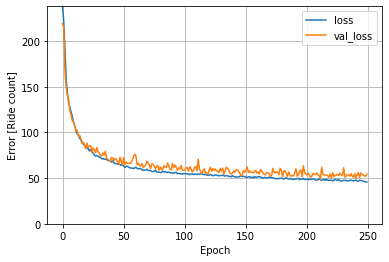

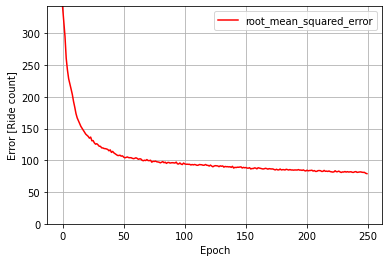

In [859]:
plot_loss(history)
plot_metric(history, metric='root_mean_squared_error', color='r')

# Testing the model

Now that we have a model built. We can test it to see how it performs against the test dataset.

We can then use the model to provide us with Ride count predictions based on the input features.  If we plot the true value from the test data against the predicted value we can see how accurate our model is. We are aiming to fit the diagonal line but overfitting can actually be a problem so if there is outlying data this is not necessarily a failure.

In [860]:
test_results = {}
test_results['model'] = model.evaluate(
    test_features, test_labels,
    verbose=1)

35/35 [==============================] - 0s 679us/step - loss: 54.2998 - root_mean_squared_error: 89.1297


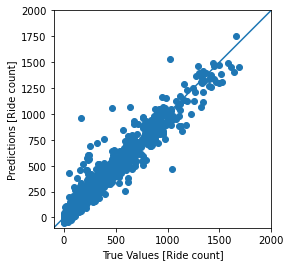

In [861]:
test_predictions = model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [Ride count]')
plt.ylabel('Predictions [Ride count]')
lims = [-100, 2000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

## Evaluating the test results
We can then do further evaluation of our test results to determine if we have a good model. First we will calculate the R2 score for the prediction. Scores closer to 1 are better.

We then plot the difference between predictions and true values.

We will also convert the difference values to a dataframe so we can gather statistical information on the distribution of values and look at the distribution of values. 

In [862]:
r2_score(test_labels.values, test_predictions)

0.933595005591241

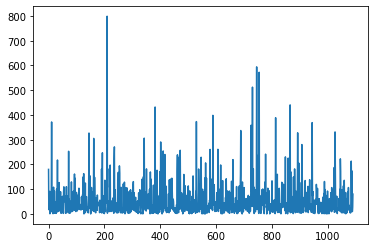

In [863]:
differences = abs(test_predictions - test_labels['Ride count'].values)
plt.plot(differences)

plt.show()

In [864]:

diff_df = pd.DataFrame(differences, columns=["Difference"])
diff_df.describe()

,Difference
count,1092.000000
mean,54.299794
std,70.712135
min,0.024109
25%,13.015930
50%,32.442345
75%,69.004120
max,798.694641


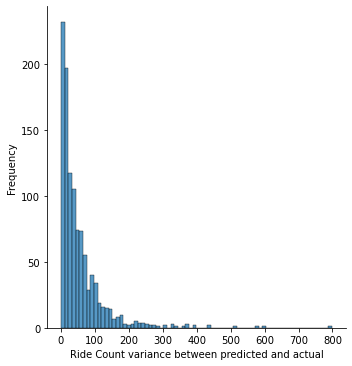

In [865]:
sns.displot(differences)
plt.xlabel("Ride Count variance between predicted and actual")
plt.ylabel("Frequency")
plt.show()

## Saving the model

Once we are satisfied with the model or want to save our progress we can export the model weights to a local file to be restored later for further training. These are just the weights for the inputs based on training and doesn't contain the full model architecture.

The second command will save the entire model including the architecture which is useful for importing into another application.

In [849]:
# model.save_weights('./checkpoint/v1')

In [866]:
model.save('./bike_share')

INFO:tensorflow:Assets written to: ./bike_share\assets
